### Agentic Model

RL Agent with a custom Reinforcement Learning (RL) environment designed using gym framework to optimize using PPO algorithm to improve time-series predictions made by xgboost model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO   # Imports the PPO algorithm
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize

path = '/data/train_df.csv'
df = pd.read_csv(path)

# Prepare the Data
df_rl = df[[
    'Predicted_Next_Purchase_Volume', 
    'lag_qty_1', 'lag_qty_2', 'lag_qty_3', 
    'Next_Purchase_Volume'
]].copy()

df_rl.columns = ['xgb_pred', 'lag_1', 'lag_2', 'lag_3', 'y_true']


class ForecastCorrectionEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        self.total_steps = len(data)
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(4,), dtype=float)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=float)
        
    def _get_obs(self):
        row = self.data.iloc[self.current_step]
        return np.array([
            row['xgb_pred'],
            row['lag_1'],
            row['lag_2'],
            row['lag_3']
        ], dtype=np.float32)

    def reset(self, **kwargs):
        self.current_step = 0
        return self._get_obs(), {}
    
    def step(self, action):
        correction = action[0]
        row = self.data.iloc[self.current_step]
        xgb_pred = row['xgb_pred']
        y_true = row['y_true']
        
        corrected = xgb_pred + correction
        base_error = abs(xgb_pred - y_true)
        corrected_error = abs(corrected - y_true)

        # Reward = improvement over XGBoost prediction
        reward = base_error - corrected_error

        # scale reward to keep in range
        reward = np.clip(reward, -10, 10)

        self.current_step += 1
        done = self.current_step >= self.total_steps
        obs = self._get_obs() if not done else np.zeros(4, dtype=np.float32)

        return obs, reward, done, False, {}

env = ForecastCorrectionEnv(df_rl)
vec_env = DummyVecEnv([lambda: env])

print("Before PPO init")

ppo_model = PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=1e-3,
    n_steps=4096,      
    batch_size=512,
    ent_coef=0.01,
    vf_coef=0.5,    
    gae_lambda=0.95,
    clip_range=0.1,
    verbose=1,
    tensorboard_log="./ppo_forecast_tensorboard/"
)

print("After PPO init")

Before PPO init
Using cpu device
After PPO init


In [61]:
from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.current_rewards = 0.0

    def _on_step(self) -> bool:
        self.current_rewards += self.locals["rewards"][0]
        # Force episode reward logging every N steps or at done
        if self.n_calls % 100 == 0 or self.locals["dones"][0]:
            self.episode_rewards.append(self.current_rewards)
            self.current_rewards = 0.0
        return True
    

# Train PPO Agent
reward_callback = RewardLoggerCallback()
ppo_model.learn(
    total_timesteps=100000, 
    callback=reward_callback,
    tb_log_name="ppo_run")       


Logging to ./ppo_forecast_tensorboard/ppo_run_35
-----------------------------
| time/              |      |
|    fps             | 5098 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 4096 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 4745         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0050583743 |
|    clip_fraction        | 0.132        |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.931       |
|    explained_variance   | 0.135        |
|    learning_rate        | 0.001        |
|    loss                 | 3.21         |
|    n_updates            | 2010         |
|    policy_gradient_loss | -0.00103     |
|    std                  | 0.613        |
|    value

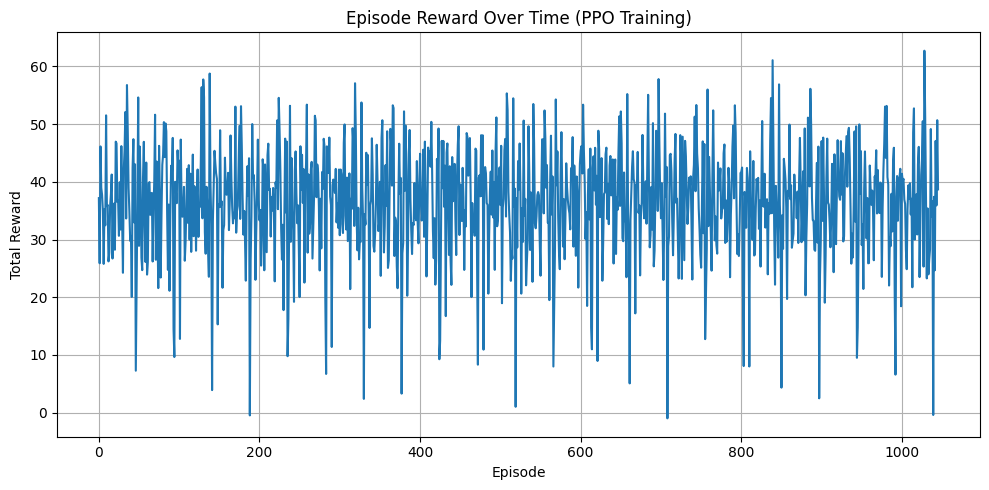

In [62]:
import matplotlib.pyplot as plt
# Plot the episode rewards
plt.figure(figsize=(10, 5))
plt.plot(reward_callback.episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Reward Over Time (PPO Training)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Othe plots - Launch TensorBoard (in terminal) - type in the same directory as the project:
# tensorboard --logdir=./ppo_forecast_tensorboard/
# output: TensorBoard 2.X at http://localhost:6006/ (Press CTRL+C to quit)
# Open that URL in your browser to see plots: Episode rewards, Loss curves, Policy entropy, Value function loss

In [63]:
# Use the Trained Agent for Prediction Correction

obs = vec_env.reset()
done = [False]

corrected_preds = []

while not done[0]:
    action, _ = ppo_model.predict(obs)
    xgb_pred = obs[0][0]  # First env, first feature (xgb_pred)
    correction = action[0][0]  # First env
    corrected_preds.append(xgb_pred + correction)
    obs, reward, done, info = vec_env.step(action)

df_rl["corrected_pred"] = corrected_preds

In [64]:
df_rl

,xgb_pred,lag_1,lag_2,lag_3,y_true,corrected_pred
0,18.215448,15.0,17.0,34.0,35.0,17.215448
1,8.336055,2.0,2.0,2.0,2.0,7.336055
2,66.316650,59.0,66.0,37.0,58.0,65.827128
3,55.727030,28.0,103.0,119.0,88.0,54.727032
4,13.273713,13.0,12.0,12.0,10.0,12.273713
...,...,...,...,...,...,...
4622,8.685681,6.0,9.0,4.0,4.0,7.685681
4623,14.502764,14.0,9.0,18.0,9.0,13.502764
4624,25.766315,36.0,3.0,9.0,8.0,26.766315
4625,9.279712,2.0,6.0,2.0,13.0,8.279712


In [65]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

y_true = df_rl["y_true"].values
y_pred = df_rl["corrected_pred"].values

rmse = root_mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 20.7778
MAE: 12.0046
R² Score: 0.4445


In [ ]:
# # Save the PPO Model
# path = '/Users/cypacyt/Documents/IAIAProject/models/ppo_model'
# ppo_model.save(path)


In [67]:
# # Load the PPO Model 
# from stable_baselines3 import PPO
# ppo_model = PPO.load(path)